## Regularization

In this notebook we shall discuss about the different regularization techniques.

We will use a synthetic regression data with two features and one target. 

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler

### Creating the synthetic dataset

In [5]:
X, y = make_regression(n_samples=500,     # number of samples in the dataset
                       n_features=2,      # number of features in the dataset
                       n_informative=2,   # number of informative features in the dataset
                       n_targets=1,       # number of targets in the dataset
                       noise=1.0)         # standard deviation of the gaussian noise applied to the dataset

y = StandardScaler().fit_transform(y.reshape(-1,1)).flatten()

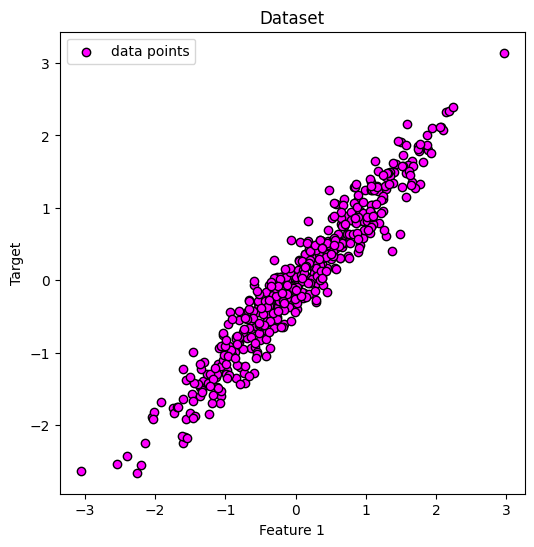

In [6]:
# plot of target (y) vs first feature (X[:,0])

plt.figure(figsize=(6,6))
plt.scatter(X[:,0], y, color='magenta', label='data points', edgecolor='k')
plt.xlabel('Feature 1')
plt.ylabel('Target')
plt.title('Dataset')
plt.legend()
plt.show()

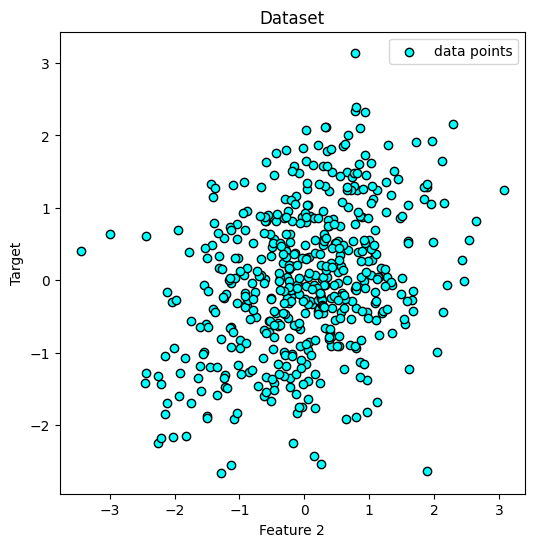

In [7]:
# plot of target (y) vs second feature (X[:,1])

plt.figure(figsize=(6,6))
plt.scatter(X[:,1], y, color='cyan', label='data points', edgecolor='k')
plt.xlabel('Feature 2')
plt.ylabel('Target')
plt.title('Dataset')
plt.legend()
plt.show()

### OLS estimation

We will fit an unregularized linear regression (ordinary least square) to estimate the parameters

In [8]:
from sklearn.linear_model import LinearRegression

In [9]:
linear_reg_model = LinearRegression()
linear_reg_model.fit(X, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [10]:
unreg_weights = linear_reg_model.coef_
bias = linear_reg_model.intercept_

print(f"Unregularized weights: {unreg_weights.round(3)}, bias: {bias:.3f}")

Unregularized weights: [1.003 0.264], bias: -0.051


### MSE Cost function

$$ J(w, b) = \frac{1}{2m} \sum_{i=1}^{m}\left(w^TX^{(i)}+b - y^{(i)}\right)^2$$

In [11]:
def mse_cost(X, weights, bias, y_actual):
    y_pred = np.dot(X, weights) + bias
    return 0.5*np.mean((y_pred - y_actual)**2)

### How the cost function depends on different values of parameters 

Now, we shall calculate the cost functions keeping one parameter fixed and varying other parameter.

In [12]:
theta_1_list = np.linspace(unreg_weights[0] - 2*abs(unreg_weights[0]), unreg_weights[0] + 2*abs(unreg_weights[0]), 100)
theta_2_list = np.linspace(unreg_weights[1] - 2*abs(unreg_weights[1]), unreg_weights[1] + 2*abs(unreg_weights[1]), 100)

cost_when_theta_1_varies = []
cost_when_theta_2_varies = []

# keeping bias and theta_2 constant and varying theta_1

for t1 in theta_1_list:
    cost_when_theta_1_varies.append(mse_cost(X, np.array([t1, unreg_weights[1]]), bias, y))

# keeping bias and theta_1 constant and varying theta_2

for t2 in theta_2_list:
    cost_when_theta_2_varies.append(mse_cost(X, np.array([unreg_weights[0], t2]), bias, y))

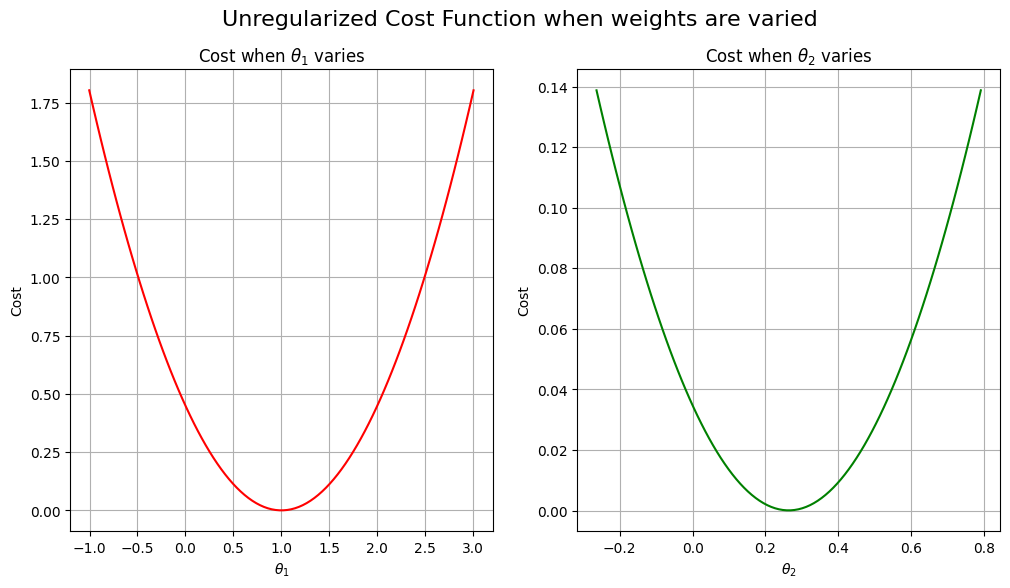

In [16]:
# plotting the cost function when the weights are varied

plt.figure(figsize=(12,6))

# theta_1 varies but theta_2 constant
plt.subplot(1,2,1)
plt.plot(theta_1_list, cost_when_theta_1_varies, 'r')
plt.xlabel('$\\theta_1$')
plt.ylabel('Cost')
plt.grid()
plt.title('Cost when $\\theta_1$ varies')

# theta_2 varies but theta_1 constant
plt.subplot(1,2,2)
plt.plot(theta_2_list, cost_when_theta_2_varies, 'g')
plt.xlabel('$\\theta_2$')
plt.ylabel('Cost')
plt.grid()
plt.title('Cost when $\\theta_2$ varies')

plt.suptitle('Unregularized Cost Function when weights are varied', fontsize=16)
plt.show()

### Contour plot of MSE cost function

Contour plot is a great visualization tool to visualize how the cost function varies when both the parameter changes. 

In [17]:
max_value = max(abs(unreg_weights[0]), abs(unreg_weights[1]))

theta_1_values_range = np.arange(-2*max_value, 2*max_value, 0.05)
theta_2_values_range = np.arange(-2*max_value, 2*max_value, 0.05)

theta_1_values, theta_2_values = np.meshgrid(theta_1_values_range, theta_2_values_range)

cost_values = []

for t1_list, t2_list in zip(theta_1_values, theta_2_values):
    cost_values.append([mse_cost(X, np.array([t1, t2]), bias, y) for t1, t2 in zip(t1_list, t2_list)])

cost_values = np.array(cost_values)

cost_values.shape

(81, 81)

In [20]:
len(theta_1_values_range), len(theta_1_values_range)

(81, 81)

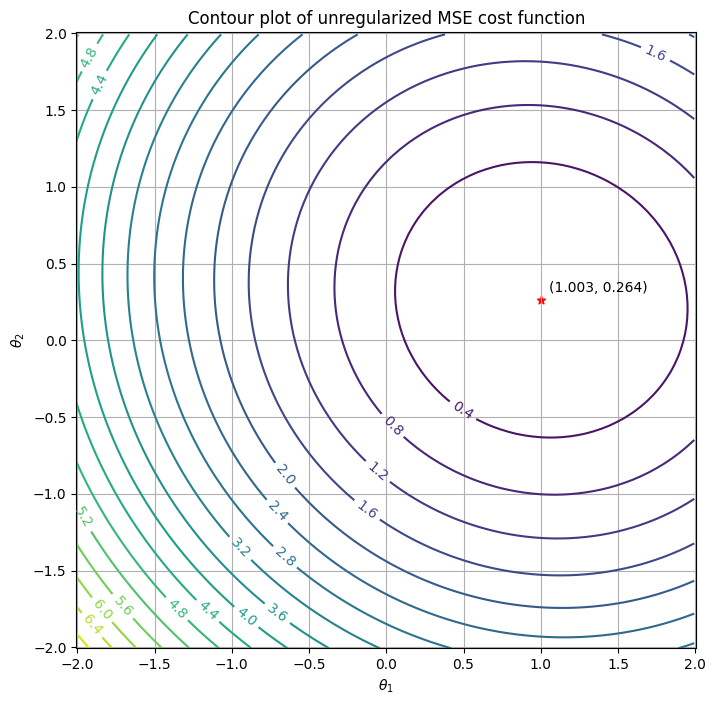

In [21]:
fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(theta_1_values, theta_2_values, cost_values, levels=20)
ax.clabel(CS, inline=1, fontsize=10)
# plotting the optimal weights
ax.scatter(unreg_weights[0], unreg_weights[1], color='red', marker='*', label='optimal weights')
plt.annotate(f"({unreg_weights[0]:.3f}, {unreg_weights[1]:.3f})", 
             xy=(unreg_weights[0], unreg_weights[1]), 
             xytext=(unreg_weights[0]+0.05 , unreg_weights[1] + 0.05),
            )
ax.set_title("Contour plot of unregularized MSE cost function")
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_xlim(-2*max_value, 2*max_value)
ax.set_ylim(-2*max_value, 2*max_value)
ax.grid(True)
plt.show()

### MSE Cost function with L2 regularization (RIDGE)

Now we will add a L2 penalty term to the cost function and see how it changes the behaviour.

The MSE cost function with L2 regularization:

$$J(w,b) = \frac{1}{2m} \left( \sum_{i=1}^{m}\left(w^TX^{(i)}+b - y^{(i)}\right)^2 + \alpha \cdot w^Tw \right)$$

In [22]:
# Defining cost function with L2 regularization

def mse_cost_l2_regularization(X, weights, bias, y_actual, alpha):
    y_pred = np.dot(X, weights) + bias
    m = X.shape[0]
    return 0.5*(1/m)*(np.sum((y_pred - y_actual)**2) + alpha*np.sum(weights**2))

With different value of alpha, we will now see how the cost function varies with different parameters.

In [27]:
theta_1_list = np.linspace(unreg_weights[0] - 2*abs(unreg_weights[0]), unreg_weights[0] + 2*abs(unreg_weights[0]), 100)
theta_2_list = np.linspace(unreg_weights[1] - 2*abs(unreg_weights[1]), unreg_weights[1] + 2*abs(unreg_weights[1]), 100)


list_of_alpha = [0, 10, 20, 50, 100]
cost_when_theta_1_varies = {a:[] for a in list_of_alpha}
cost_when_theta_2_varies = {a:[] for a in list_of_alpha}

# keeping bias and theta_2 constant and varying theta_1

for alpha in list_of_alpha:
    for t1 in theta_1_list:
        cost_when_theta_1_varies[alpha].append(mse_cost_l2_regularization(X, np.array([t1, unreg_weights[1]]), bias, y, alpha))

# keeping bias and theta_1 constant and varying theta_2

for alpha in list_of_alpha:
    for t2 in theta_2_list:
        cost_when_theta_2_varies[alpha].append(mse_cost_l2_regularization(X, np.array([unreg_weights[0], t2]), bias, y, alpha))

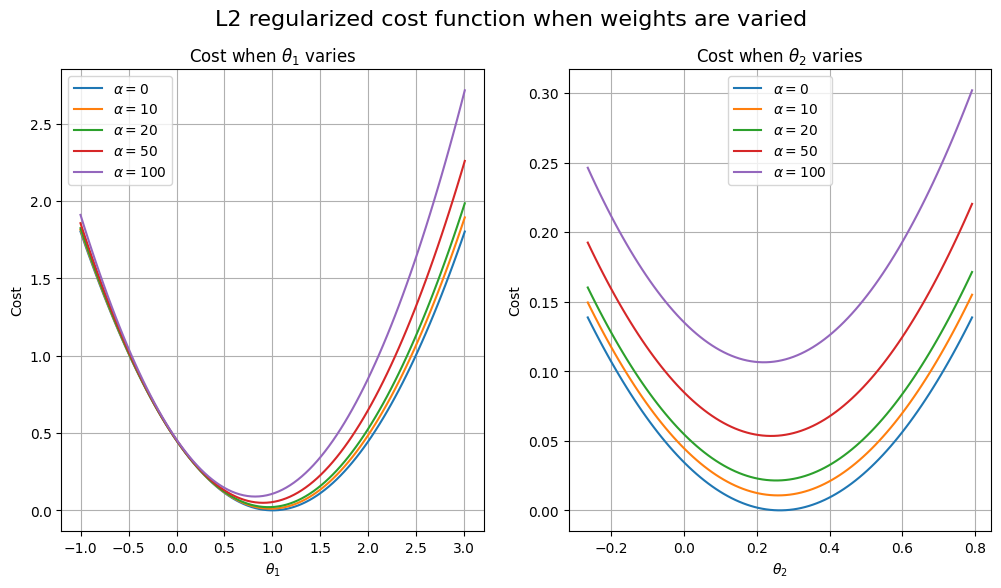

In [28]:
# plotting the cost function when the weights are varied

plt.figure(figsize=(12,6))

# theta_1 varies but theta_2 constant
plt.subplot(1,2,1)
for alpha in list_of_alpha:
    plt.plot(theta_1_list, cost_when_theta_1_varies[alpha], label=f'$\\alpha = {alpha}$')
plt.xlabel('$\\theta_1$')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.title('Cost when $\\theta_1$ varies')

# theta_2 varies but theta_1 constant
plt.subplot(1,2,2)
for alpha in list_of_alpha:
    plt.plot(theta_2_list, cost_when_theta_2_varies[alpha], label=f'$\\alpha = {alpha}$')
plt.xlabel('$\\theta_2$')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.title('Cost when $\\theta_2$ varies')

plt.suptitle('L2 regularized cost function when weights are varied', fontsize=16)
plt.show()

### Ridge regression in sklearn

sklearn Ridge documetnation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

In [29]:
from sklearn.linear_model import Ridge

alpha = 50

l2_reg_model = Ridge(alpha=alpha, fit_intercept=True)

l2_reg_model.fit(X, y)

reg_weights = l2_reg_model.coef_
reg_bias = l2_reg_model.intercept_

print(f"Regularized weights: {reg_weights.round(3)}, bias: {reg_bias:.3f}")

Regularized weights: [0.903 0.245], bias: -0.046


In [34]:
mse_cost_l2_regularization(X, np.array(reg_weights), reg_bias, y, alpha=alpha)

np.float64(0.04861581778808145)

In [35]:
mse_cost_l2_regularization(X, np.array(unreg_weights), bias, y, alpha=alpha)

np.float64(0.053874124116995735)

### Contour plot of MSE cost function with L2 regularization

In [30]:
max_value = max(abs(reg_weights[0]), abs(reg_weights[1]))

theta_1_values_range = np.arange(-2*max_value, 2*max_value, 0.05)
theta_2_values_range = np.arange(-2*max_value, 2*max_value, 0.05)

theta_1_values, theta_2_values = np.meshgrid(theta_1_values_range, theta_2_values_range)

cost_values = []

for t1_list, t2_list in zip(theta_1_values, theta_2_values):
    cost_values.append([mse_cost_l2_regularization(X, np.array([t1, t2]), reg_bias, y, alpha=alpha) for t1, t2 in zip(t1_list, t2_list)])

cost_values = np.array(cost_values)

cost_values.shape

(73, 73)

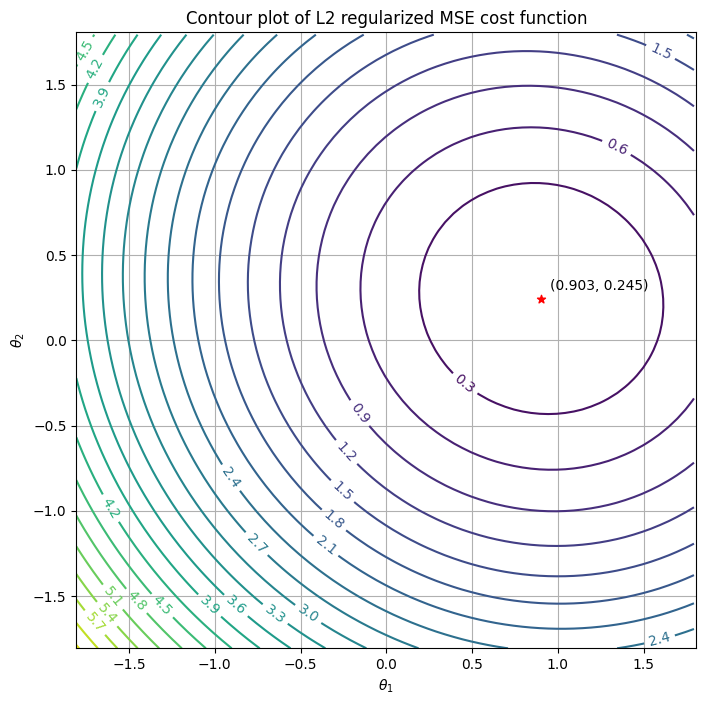

In [31]:
fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(theta_1_values, theta_2_values, cost_values, levels=20)
ax.clabel(CS, inline=1, fontsize=10)
ax.scatter(reg_weights[0], reg_weights[1], color='red', marker='*', label='Initial weights')
plt.annotate(f"({reg_weights[0]:.3f}, {reg_weights[1]:.3f})",
             xy=(reg_weights[0], reg_weights[1]), 
             xytext=(reg_weights[0]+0.05 , reg_weights[1] + 0.05),
            )
ax.set_title("Contour plot of L2 regularized MSE cost function")
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_xlim(-2*max_value, 2*max_value)
ax.set_ylim(-2*max_value, 2*max_value)
ax.grid(True)
plt.show()

### MSE cost function with L1 regularization (LASSO)

The MSE cost function with L1 regularization:

$$J(w,b) = \frac{1}{2m} \sum_{i=1}^{m}\left(w^TX^{(i)}+b - y^{(i)}\right)^2 + \alpha \cdot \sum_{j=1}^k |w_j| $$

In [37]:
def mse_cost_l1_regularization(X, weights, bias, y_actual, alpha):
    y_pred = np.dot(X, weights) + bias
    return 0.5*np.mean((y_pred - y_actual)**2) + alpha*np.sum(np.abs(weights))

In [38]:
theta_1_list = np.linspace(unreg_weights[0] - 2*abs(unreg_weights[0]), unreg_weights[0] + 2*abs(unreg_weights[0]), 100)
theta_2_list = np.linspace(unreg_weights[1] - 2*abs(unreg_weights[1]), unreg_weights[1] + 2*abs(unreg_weights[1]), 100)


list_of_alpha = [0, 0.1, 0.2, 0.5, 1.0, 2.0]
cost_when_theta_1_varies = {a:[] for a in list_of_alpha}
cost_when_theta_2_varies = {a:[] for a in list_of_alpha}

# keeping bias and theta_2 constant and varying theta_1

for alpha in list_of_alpha:
    for t1 in theta_1_list:
        cost_when_theta_1_varies[alpha].append(mse_cost_l1_regularization(X, np.array([t1, unreg_weights[1]]), bias, y, alpha))

# keeping bias and theta_1 constant and varying theta_2

for alpha in list_of_alpha:
    for t2 in theta_2_list:
        cost_when_theta_2_varies[alpha].append(mse_cost_l1_regularization(X, np.array([unreg_weights[0], t2]), bias, y, alpha))

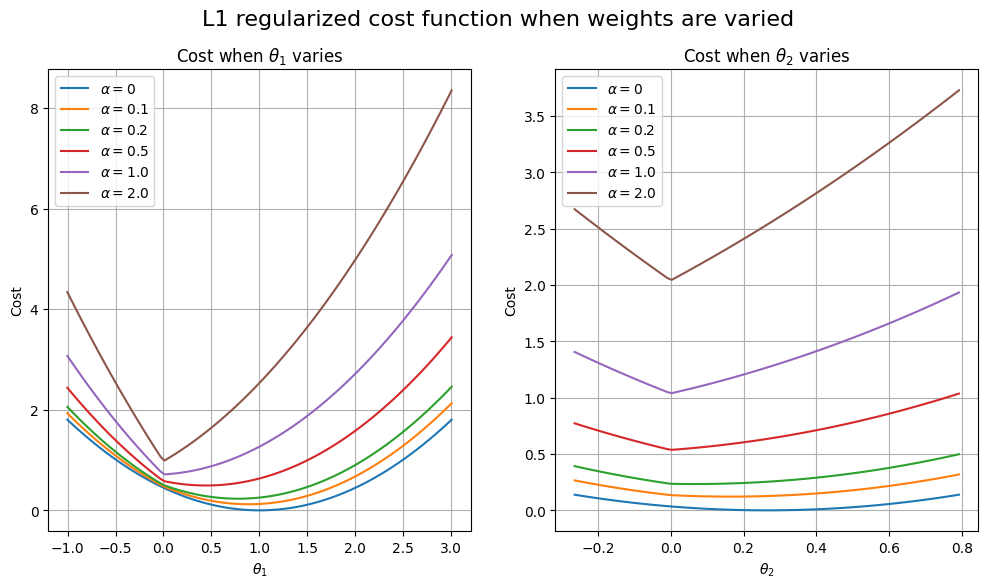

In [39]:
# plotting the cost function when the weights are varied

plt.figure(figsize=(12,6))

# theta_1 varies but theta_2 constant
plt.subplot(1,2,1)
for alpha in list_of_alpha:
    plt.plot(theta_1_list, cost_when_theta_1_varies[alpha], label=f'$\\alpha = {alpha}$')
plt.xlabel('$\\theta_1$')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.title('Cost when $\\theta_1$ varies')

# theta_2 varies but theta_1 constant
plt.subplot(1,2,2)
for alpha in list_of_alpha:
    plt.plot(theta_2_list, cost_when_theta_2_varies[alpha], label=f'$\\alpha = {alpha}$')
plt.xlabel('$\\theta_2$')
plt.ylabel('Cost')
plt.grid()
plt.legend()
plt.title('Cost when $\\theta_2$ varies')

plt.suptitle('L1 regularized cost function when weights are varied', fontsize=16)
plt.show()

### Lasso regression in sklearn

sklearn Lasso documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html

In [46]:
from sklearn.linear_model import Lasso

alpha = 0.3

l1_reg_model = Lasso(alpha=alpha, fit_intercept=True)

l1_reg_model.fit(X, y)

reg_weights = l1_reg_model.coef_
reg_bias = l1_reg_model.intercept_

print(f"Regularized weights: {reg_weights.round(3)}, bias: {reg_bias:.3f}")

Regularized weights: [0.685 0.   ], bias: -0.034


### Contour plot of MSE cost function with L1 regularization

In [47]:
max_value = max(abs(reg_weights[0]), abs(reg_weights[1]))

theta_1_values_range = np.arange(-2*max_value, 2*max_value, 0.05)
theta_2_values_range = np.arange(-2*max_value, 2*max_value, 0.05)

theta_1_values, theta_2_values = np.meshgrid(theta_1_values_range, theta_2_values_range)

cost_values = []

for t1_list, t2_list in zip(theta_1_values, theta_2_values):
    cost_values.append([mse_cost_l1_regularization(X, np.array([t1, t2]), reg_bias, y, alpha=alpha) for t1, t2 in zip(t1_list, t2_list)])

cost_values = np.array(cost_values)

cost_values.shape

(55, 55)

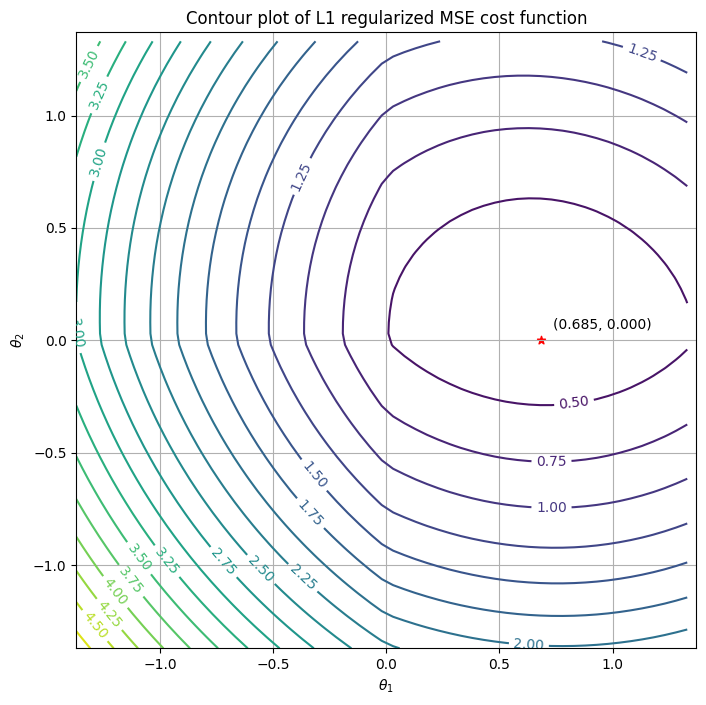

In [48]:
fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(theta_1_values, theta_2_values, cost_values, levels=20)
ax.clabel(CS, inline=1, fontsize=10)
ax.scatter(reg_weights[0], reg_weights[1], color='red', marker='*', label='Initial weights')
plt.annotate(f"({reg_weights[0]:.3f}, {reg_weights[1]:.3f})",
             xy=(reg_weights[0], reg_weights[1]), 
             xytext=(reg_weights[0]+0.05 , reg_weights[1] + 0.05),
            )
ax.set_title("Contour plot of L1 regularized MSE cost function")
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_xlim(-2*max_value, 2*max_value)
ax.set_ylim(-2*max_value, 2*max_value)
ax.grid(True)
plt.show()

### MSE Cost function with ElasticNet (L1 + L2) Regularization

The MSE cost function with ElasticNet regularization:

$$J(w,b) = \frac{1}{2m} \sum_{i=1}^{m}\left(w^TX^{(i)}+b - y^{(i)}\right)^2 + \alpha \left(\beta \sum_{j=1}^k |w_j| + \frac{1-\beta}{2} \sum_{j=1}^{k} w_j^2 \right)$$

In [49]:
def mse_cost_l1_l2_regularization(X, weights, bias, y_actual, alpha, l1_ratio):
    y_pred = np.dot(X, weights) + bias
    regularization_term = alpha * (l1_ratio * np.sum(np.abs(weights)) + 0.5 * (1 - l1_ratio) * np.sum(weights**2))
    return 0.5*np.mean((y_pred - y_actual)**2) + regularization_term

In [50]:
theta_1_list = np.linspace(unreg_weights[0] - 2*abs(unreg_weights[0]), unreg_weights[0] + 2*abs(unreg_weights[0]), 100)
theta_2_list = np.linspace(unreg_weights[1] - 2*abs(unreg_weights[1]), unreg_weights[1] + 2*abs(unreg_weights[1]), 100)

list_of_alpha = [0, 0.2, 0.5, 1.0, 2.0]
list_of_l1_ratio = [0, 0.25, 0.5, 1.0]

cost_when_theta_1_varies = {(a,l):[] for l in list_of_l1_ratio for a in list_of_alpha}
cost_when_theta_2_varies = {(a,l):[] for l in list_of_l1_ratio for a in list_of_alpha}

# keeping bias and theta_2 constant and varying theta_1

for alpha in list_of_alpha:
    for l1_ratio in list_of_l1_ratio:
        for t1 in theta_1_list:
            cost_when_theta_1_varies[(alpha,l1_ratio)].append(mse_cost_l1_l2_regularization(X, np.array([t1, unreg_weights[1]]), bias, y, alpha, l1_ratio))

# keeping bias and theta_1 constant and varying theta_2

for alpha in list_of_alpha:
    for l1_ratio in list_of_l1_ratio:
        for t2 in theta_2_list:
            cost_when_theta_2_varies[(alpha,l1_ratio)].append(mse_cost_l1_l2_regularization(X, np.array([unreg_weights[0], t2]), bias, y, alpha, l1_ratio))

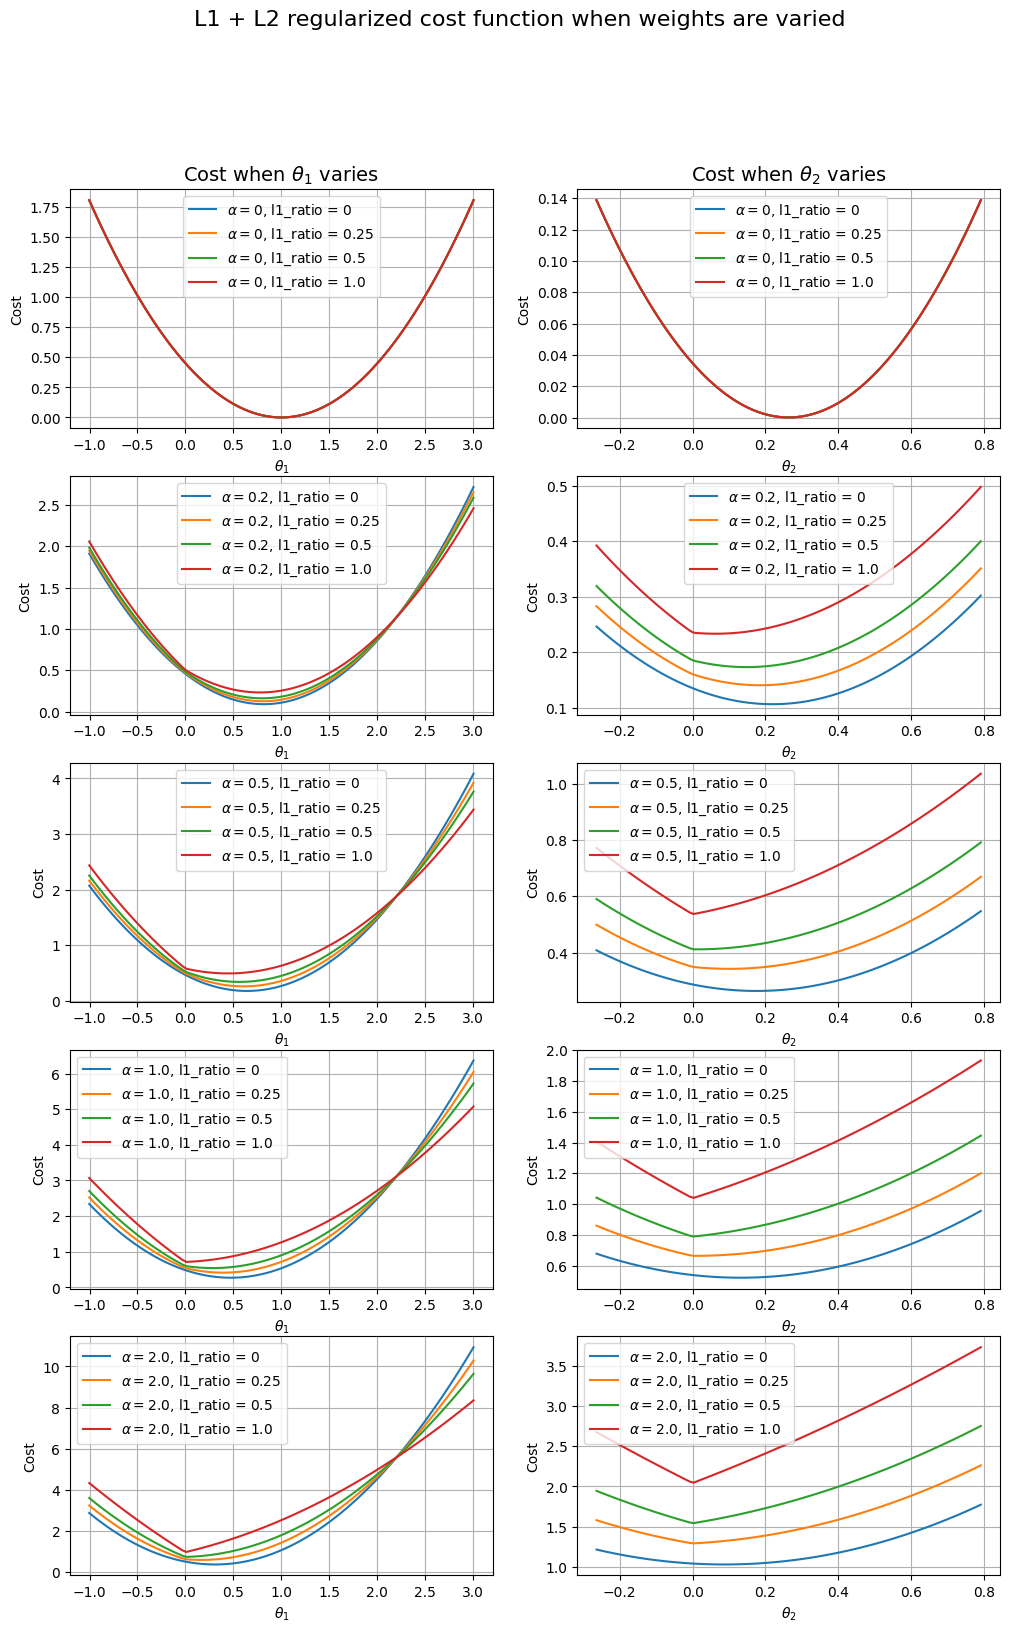

In [51]:
# plotting the cost function when the weights are varied

plt.figure(figsize=(12,18))
rows = len(list_of_alpha)

# theta_1 varies but theta_2 constant

for i, alpha in enumerate(list_of_alpha):
    plt.subplot(rows,2,2*i+1)
    for l1_ratio in list_of_l1_ratio:
        plt.plot(theta_1_list, cost_when_theta_1_varies[(alpha,l1_ratio)], label=f'$\\alpha = {alpha}$, l1_ratio = {l1_ratio}')
    plt.xlabel('$\\theta_1$')
    plt.ylabel('Cost')
    plt.grid()
    plt.legend()
    if i == 0:
        plt.title('Cost when $\\theta_1$ varies', fontsize=14)

# theta_2 varies but theta_1 constant

for i, alpha in enumerate(list_of_alpha):
    plt.subplot(rows,2,2*i+2)
    for l1_ratio in list_of_l1_ratio:
        plt.plot(theta_2_list, cost_when_theta_2_varies[(alpha, l1_ratio)], label=f'$\\alpha = {alpha}$, l1_ratio = {l1_ratio}')
    plt.xlabel('$\\theta_2$')
    plt.ylabel('Cost')
    plt.grid()
    plt.legend()
    if i == 0:
        plt.title('Cost when $\\theta_2$ varies', fontsize = 14)

plt.suptitle('L1 + L2 regularized cost function when weights are varied', fontsize=16)
plt.show()

### ElasticNet regression in sklearn

sklearn ElasticNet documentation: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html

In [54]:
from sklearn.linear_model import ElasticNet

alpha = 0.5
l1_ratio = 0.25

elasticnet_model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, fit_intercept=True)

elasticnet_model.fit(X,y)

reg_weights = elasticnet_model.coef_
reg_bias = elasticnet_model.intercept_

print(f"Regularized weights: {reg_weights.round(3)}, bias: {reg_bias:.3f}")

Regularized weights: [0.615 0.117], bias: -0.031


### Contour plot of MSE cost function with L1+L2 Regularization

In [55]:
max_value = max(abs(reg_weights[0]), abs(reg_weights[1]))

theta_1_values_range = np.arange(-2*max_value, 2*max_value, 0.05)
theta_2_values_range = np.arange(-2*max_value, 2*max_value, 0.05)

theta_1_values, theta_2_values = np.meshgrid(theta_1_values_range, theta_2_values_range)

cost_values = []

for t1_list, t2_list in zip(theta_1_values, theta_2_values):
    cost_values.append([mse_cost_l1_l2_regularization(X, np.array([t1, t2]), reg_bias, y, alpha=alpha, l1_ratio=l1_ratio) for t1, t2 in zip(t1_list, t2_list)])

cost_values = np.array(cost_values)

cost_values.shape

(50, 50)

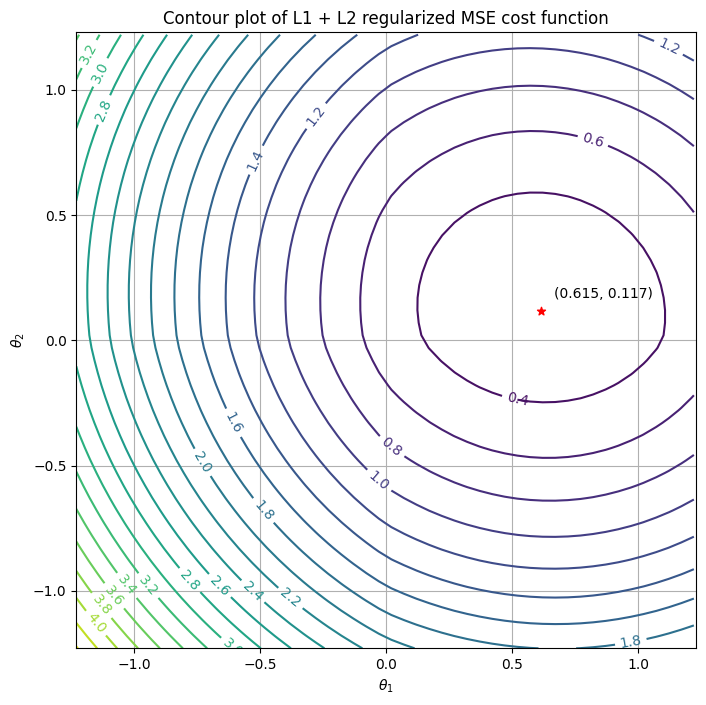

In [56]:
fig, ax = plt.subplots(figsize=(8,8))
CS = ax.contour(theta_1_values, theta_2_values, cost_values, levels=20)
ax.clabel(CS, inline=1, fontsize=10)
ax.scatter(reg_weights[0], reg_weights[1], color='red', marker='*', label='Initial weights')
plt.annotate(f"({reg_weights[0]:.3f}, {reg_weights[1]:.3f})",
             xy=(reg_weights[0], reg_weights[1]), 
             xytext=(reg_weights[0]+0.05 , reg_weights[1] + 0.05),
            )
ax.set_title("Contour plot of L1 + L2 regularized MSE cost function")
ax.set_xlabel("$\\theta_1$")
ax.set_ylabel("$\\theta_2$")
ax.set_xlim(-2*max_value, 2*max_value)
ax.set_ylim(-2*max_value, 2*max_value)
ax.grid(True)
plt.show()